# PASSO 0 - SETUP

## <i><font color="#708090" size=5>0.0 IMPORTS</font></i>

In [2]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import inflection
import math
import matplotlib.pyplot   as plt
import xgboost             as xgb
import random
import warnings
import pickle
import requests
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats     as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from flask                 import Flask, request, Response

## <i><font color="#708090" size=5>0.1 HELPER FUNCTIONS</font></i>

<b>Nota 1:</b>
Cramér's V: é uma medida de associação (correlação) entre duas variáveis categóricas,
cuja análise é baseada apenas nos nomes das variáveis. 
Explicação detalhada do cálculo em: 
<a>https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V</a>

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 )))

<b>Nota 2:</b>
jupyter_settings configura a exibição dos gráficos plotados na tela pela classe seaborn 

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

<b>Nota 3:</b>
ml_error retorna os erros do modelo ML

In [5]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

<b>Nota 4:</b>
cross_validation retorna um dataframe com os erros do modelo ML após a cross-validation

In [6]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold + 1 )):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # traning and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        mod = model.fit( xtraining, ytraining )

        # prediction
        yhat = mod.predict( xvalidation )

        # performance
        mod_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( mod_result['MAE'])
        mape_list.append( mod_result['MAPE'])
        rmse_list.append( mod_result['RMSE'])

    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, 
                         index=[0] )

## <i><font color="#708090" size=5>0.2 LOADING DATA</font></i>

In [7]:
df_sales_raw = pd.read_csv( '~/repos/DataScience_Em_Producao/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '~/repos/DataScience_Em_Producao/data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# settings plot
jupyter_settings()

# ignore warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


/home/geordano/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1º PASSO - Descrição dos Dados

In [11]:
# secutiry copy of dataset
df1 = df_raw.copy()

## <i><font color="#708090" size=5>1.1 Rename Columns</font></i>

In [12]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## <i><font color="#708090" size=5>1.2 Data Dimensions</font></i>

In [13]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## <i><font color="#708090" size=5>1.3 Data Types</font></i>

In [14]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## <i><font color="#708090" size=5>1.4 Check NA</font></i>

In [15]:
# sum of NA rows
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## <i><font color="#708090" size=5>1.5 Fillout NA</font></i>

In [16]:
#competition_distance            NA=2642
df1['competition_distance'] = df1['competition_distance'].apply( 
    lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    NA=323348
df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
    else x['competition_open_since_month'], axis=1 )

#competition_open_since_year     NA=323348
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
    else x['competition_open_since_year'], axis=1 )

#promo2_since_week               NA=508031
df1['promo2_since_week'] = df1.apply( 
    lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
    else x['promo2_since_week'], axis=1 )

#promo2_since_year               NA=508031
df1['promo2_since_year'] = df1.apply( 
    lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
    else x['promo2_since_year'], axis=1 )

#promo_interval                  NA=508031
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


In [17]:
df1.sample(5).T

,568054,795613,732869,978856,918851
store,190,289,1100,672,877
day_of_week,5,4,5,1,6
date,2014-02-07 00:00:00,2013-07-18 00:00:00,2013-09-13 00:00:00,2013-02-04 00:00:00,2013-03-30 00:00:00
sales,6969,7028,6470,11521,7958
customers,673,566,852,1720,1050
open,1,1,1,1,1
promo,1,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,1,0
store_type,a,d,a,c,a


In [18]:
# checkout all NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## <i><font color="#708090" size=5>1.6 Change Types</font></i>

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 

## <i><font color="#708090" size=5>1.7 Descriptive Statistical</font></i>

In [21]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]']) 

### 1.7.1 Numerical Attributes

In [22]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( np.min )).T
d3 = pd.DataFrame( num_attributes.apply( np.max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 
                   'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


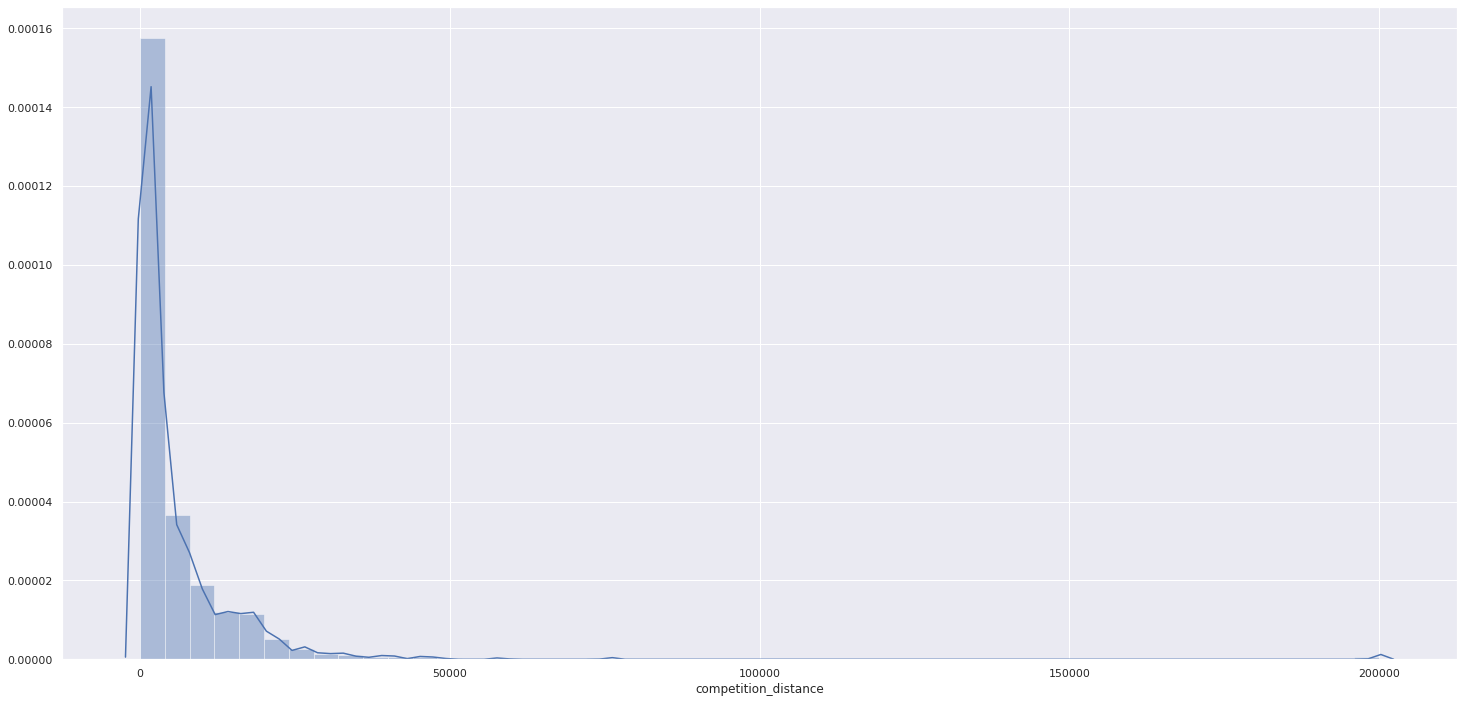

In [23]:
sns.distplot( df1['competition_distance'] );

### 1.7.2 Categorical Attributes

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

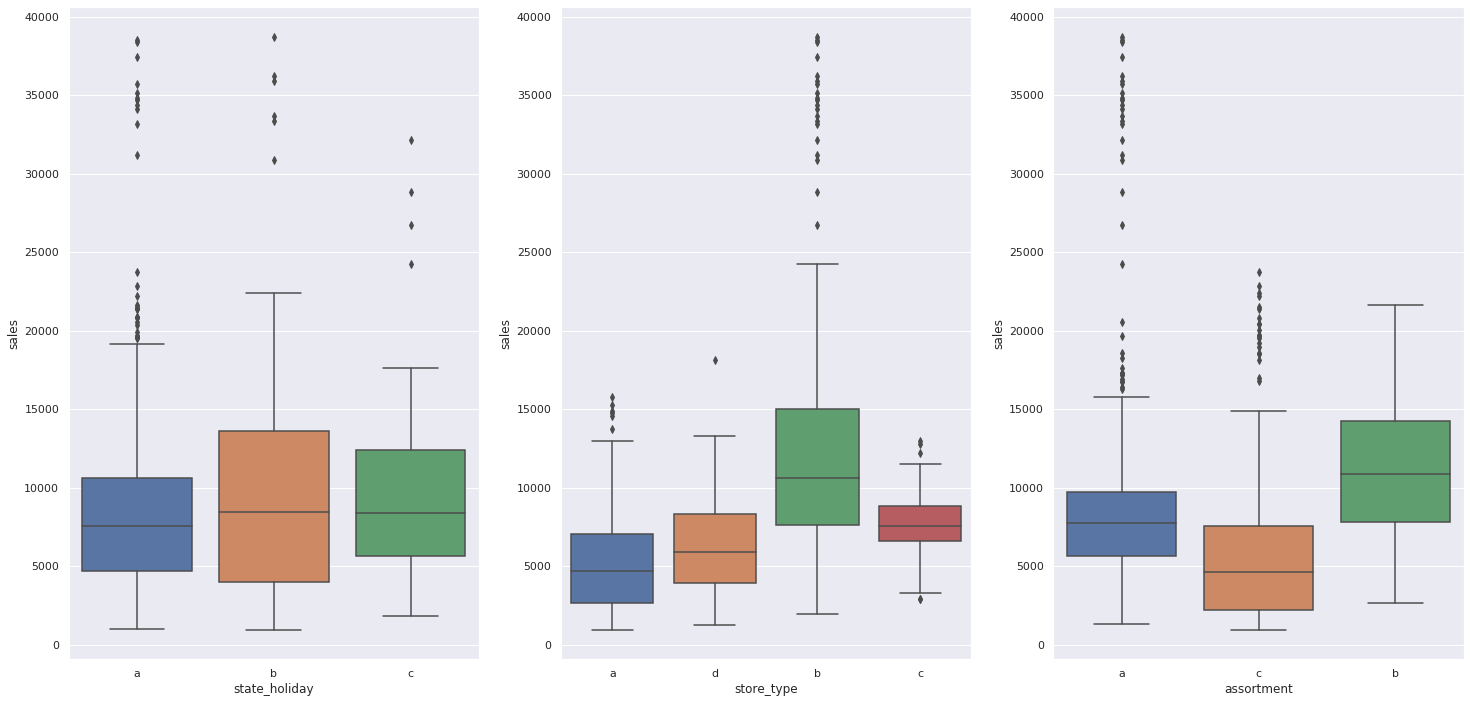

In [25]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2º PASSO - Feature Engineering

In [26]:
# secutiry copy of dataset
df2 = df1.copy()

## <i><font color="#708090" size=5>2.1 Mapa Mental de Hipóteses</font></i>

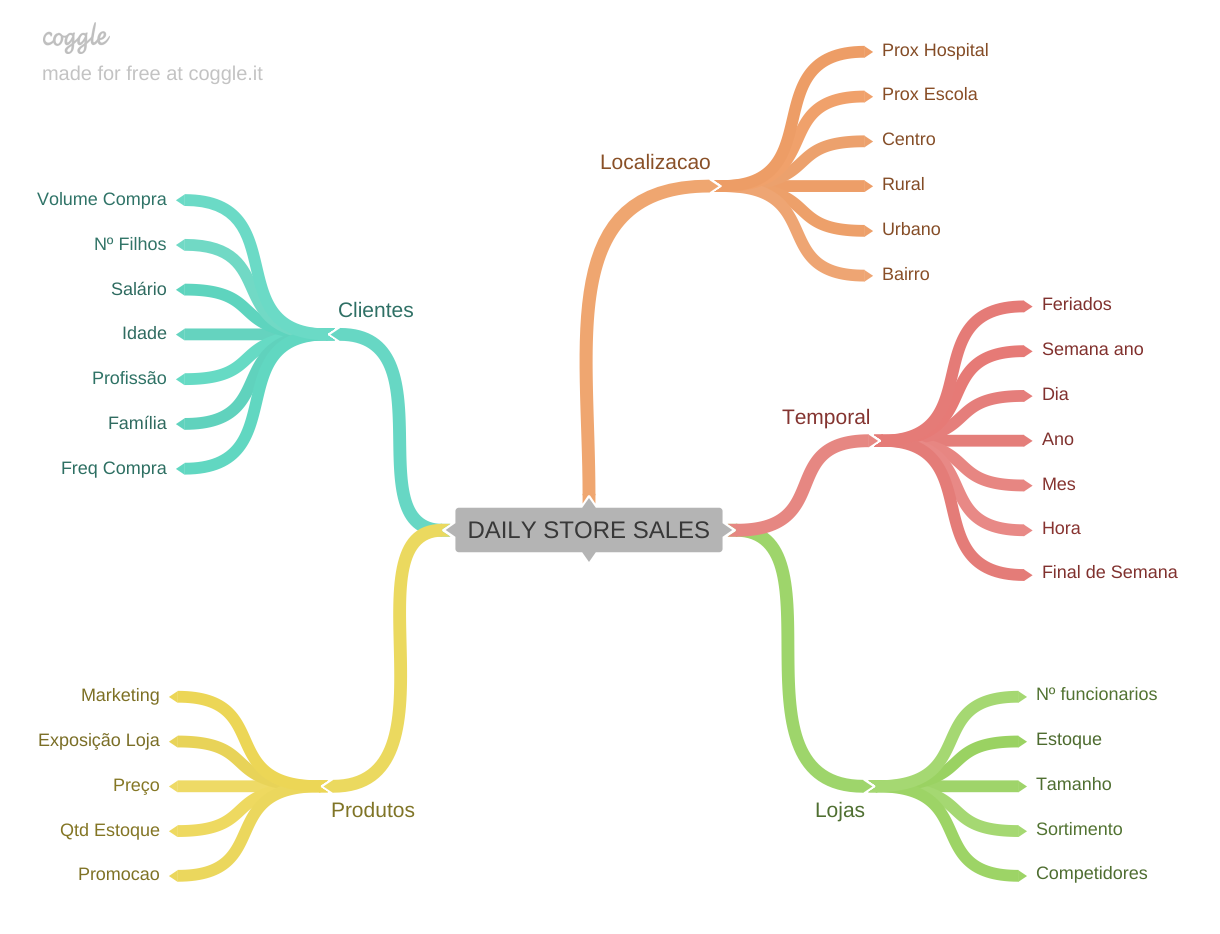

In [27]:
Image('img/MindMapHypothesis.png')

## <i><font color="#708090" size=5>2.2 Criação das Hipóteses</font></i>

### <i><font color="a9a9a9" size=4>2.2.1 Hipóteses de Lojas</font></i>

**1.** Lojas com maior nº de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior tamanho deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### <i><font color="a9a9a9" size=4>2.2.2 Hipóteses de Produto</font></i>

**1.** Lojas com maior investimento em Marketing deveriam vender mais.

**2.** Lojas com Produtos com maior esposição nas vitrines deveriam vender mais.

**3.** Lojas com Produtos com menores preços deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoções deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### <i><font color="a9a9a9" size=4>2.2.3 Hipóteses de Tempo</font></i>

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## <i><font color="#708090" size=5>2.3 Lista Final de Hipóteses</font></i>

**Hipóteses validáveis diretamente a partir do dataset**


**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoções deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## <i><font color="#708090" size=5>2.4 Feature Engineering</font></i>

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( 
                                                year=x['competition_open_since_year'],
                                                month=x['competition_open_since_month'],
                                                day=1 ), axis=1 )
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: 
                    datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 
                                             'basic' if x=='a' else
                                             'extra' if x=='b' else
                                             'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 
                                             'public_holiday' if x=='a' else
                                             'easter_holiday' if x=='b' else
                                             'christmas'      if x=='c' else
                                             'regular_day')


In [29]:
df2.sample(5).T

,523806,5733,226996,243437,661040
store,542,159,652,610,631
day_of_week,3,7,5,3,6
date,2014-03-19 00:00:00,2015-07-26 00:00:00,2015-01-09 00:00:00,2014-12-24 00:00:00,2013-11-16 00:00:00
sales,6399,0,6751,3014,4642
customers,560,0,668,370,577
open,1,0,1,1,1
promo,1,0,1,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,1,0
store_type,a,d,a,a,d


# 3º PASSO - Filtragem de Variáveis

In [30]:
# secutiry copy of dataset
df3 = df2.copy()

## <i><font color="#708090" size=5>3.1 Filtragem das Linhas</font></i>

In [31]:
# não interessa ao modelo open == 0, ou seja, quando as lojas estão fechadas
# não interessa ao modelo sales == 0, ou seja, quando as lojas estão fechadas

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## <i><font color="#708090" size=5>3.2 Seleção das Colunas</font></i>

In [32]:
# 'customers' - não há como prever a quantidade de clientes nas pŕoximas 6 semanas
# 'open' - após a filtragem das linhas, esta coluna só possui valores iguais a 1
# 'promo_interval', 'month_map' - colunas auxiliares irrelevantes para esta etapa

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4º PASSO - EDA (Análise Exploratória dos Dados)

In [34]:
# secutiry copy of dataset
df4 = df3.copy()

## <i><font color="#708090" size=5>4.1. Análise Univariada</font></i>

### <i><font color="a9a9a9" size=4>4.1.1 Response Variable</font></i>

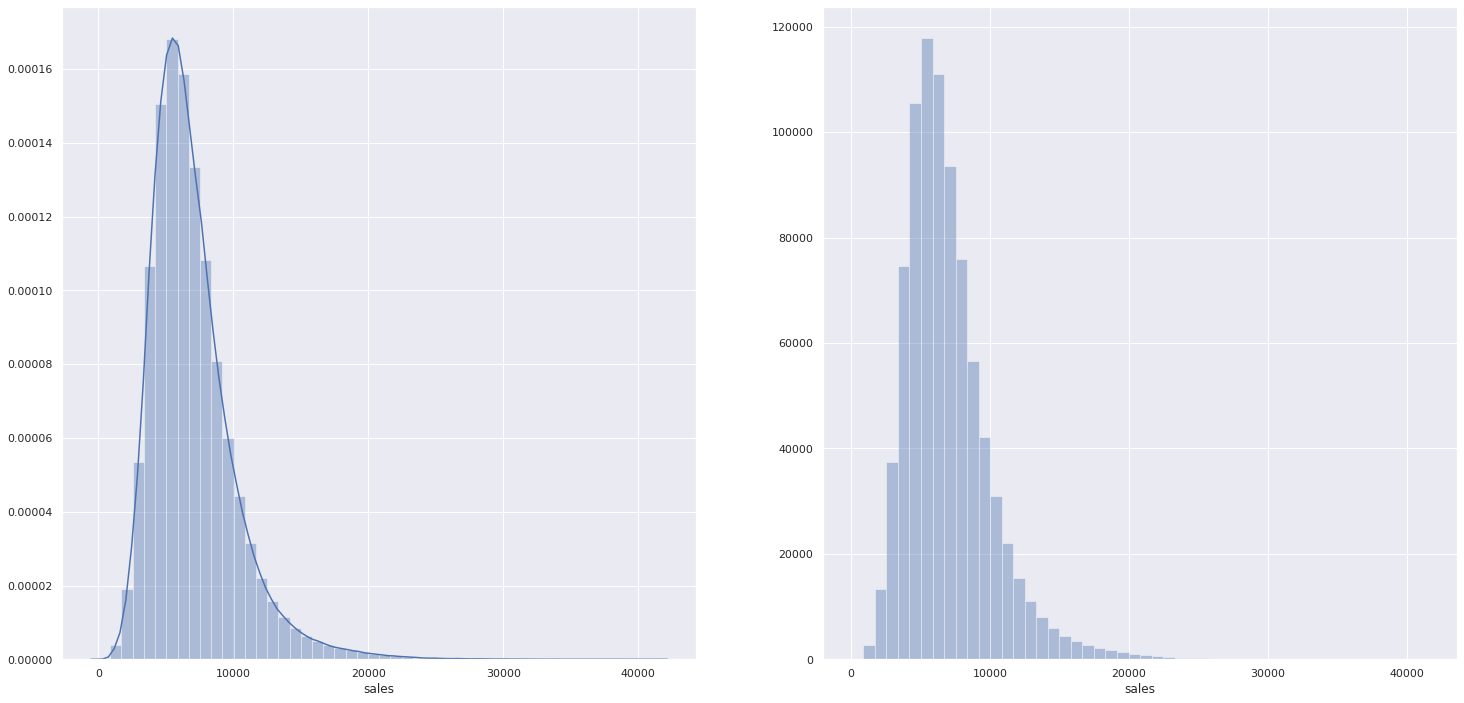

In [35]:
# ditribuição da variável resposta 'sales'
plt.subplot(1, 2, 1)
sns.distplot(df4['sales'])

# histograma da variável resposta 'sales'
plt.subplot(1, 2, 2)
sns.distplot(df4['sales'], kde=False)

### <i><font color="a9a9a9" size=4>4.1.2 Numerical Variable</font></i>

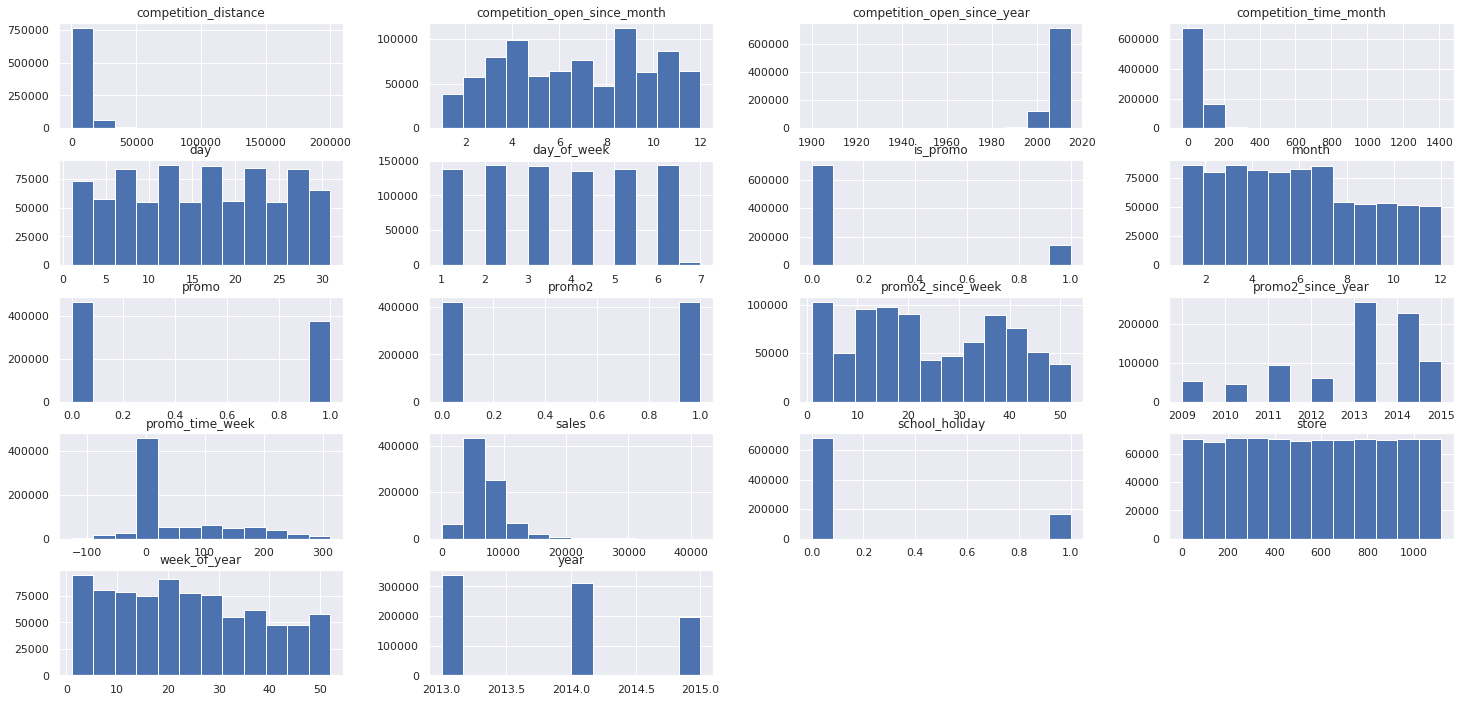

In [36]:
# histogramas de todas as variáveis numéricas do dataset
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist(bins=12);

In [37]:
# variaveis com pouca variabilidade possuem pouca relevância para o aprendizado do modelo: 'day_of_week'
# o contrário vale para a variável 'promo2_since_week' que possui alta variabilidade

# 'competition_distance': os competidores estão a uma distância muito pequena das lojas
# 'competition_open_since_month': a maioria dos competidores abriram há 9 ou 4 meses

### <i><font color="a9a9a9" size=4>4.1.3 Categorical Variable</font></i>

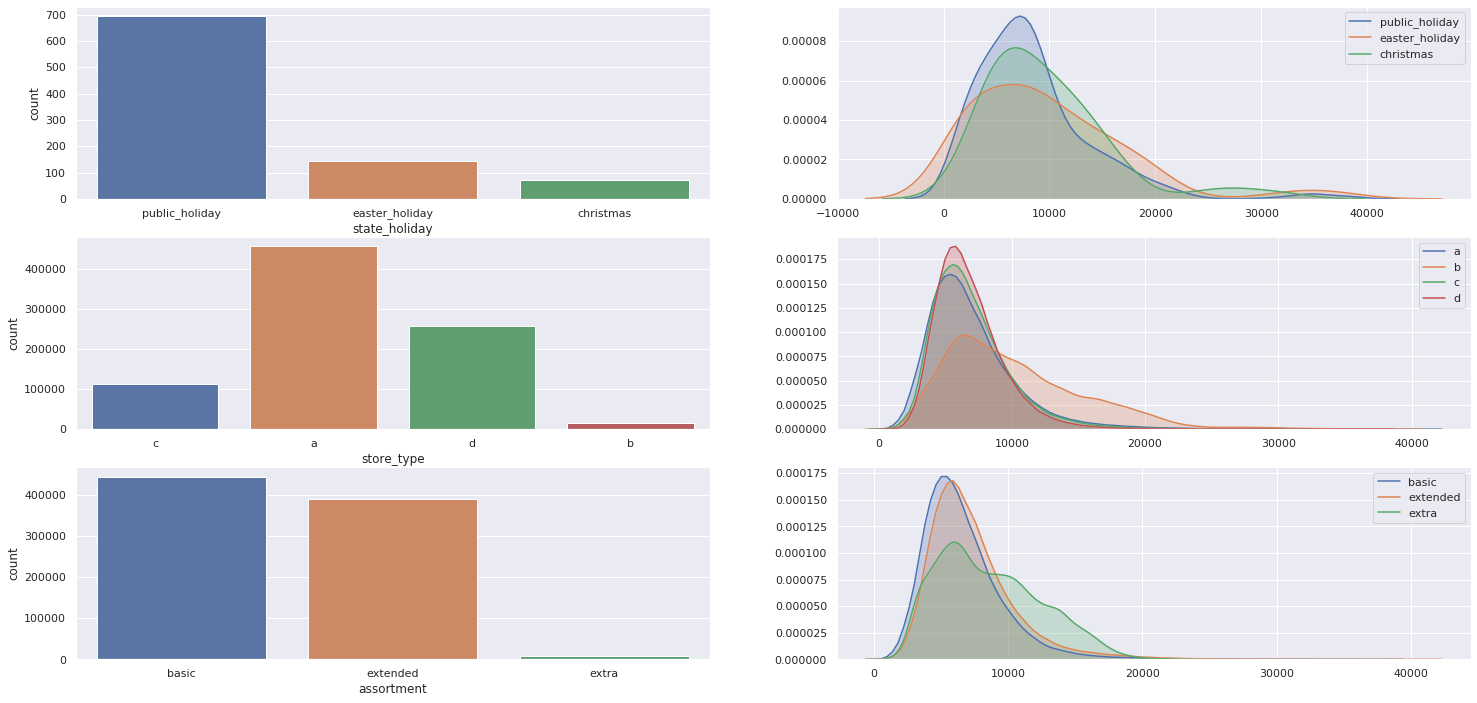

In [38]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], 
            label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], 
            label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], 
            label='christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], 
            label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], 
            label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], 
            label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], 
            label='d', shade=True )

# assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], 
            label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], 
            label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], 
            label='extra', shade=True )

## <i><font color="#708090" size=5 >4.2. Análise Bivariada</font></i>

### <i><font color="#a9a9a9" size=4>4.2.1 Validação das Hipóteses</font></i>

#### **H1.** Lojas com maior sortimento deveriam vender mais.

**FALSE:** Lojas com **MAIOR SORTIMENTO** (assortment == 'extra') vendem **MENOS**

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: YES** >> Dois comportamentos distintos com uma única variável 

In [ ]:
# Montante de vendas por tipo de assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Montante de vendas ao longo das semanas dos anos por tipo de assortment
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot();

# Montante de vendas ao longo das semanas dos anos por tipo de assortment=='extra'
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot();

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSE:** Lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS**

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Correlação de Pearson fraca

In [ ]:
# Montante de vendas por distância dos competidores
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(2,2,1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

# Correlação entre 'competition_distance' e 'sales'
plt.subplot(2,2,2)
sns.heatmap( aux1.corr( method='pearson'), annot=True);
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

# Agrupamento das distâncias dos competidores de 1000 em 1000
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )

# Montante de vendas por grupos de distâncias
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(2,2,(3,4))
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

#### **H3.** Lojas com competidores há mais tempo deveriam vender mais.

**FALSE:** Quanto **MAIS RECENTE** é a **COMPETIÇÃO**, **MAIS** as lojas vendem

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Correlação de Pearson fraca

In [ ]:
# montante de vendas pelo tempo (em meses) que os competidores abriram, antes ou depois da venda
# valores positivos indicam que a venda foi feita depois da abertura do competidor
# valores negativos indicam que o competidor abriu depois do registro daquela venda
plt.subplot(2,2,(1,2))
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Correlação entre 'competition_time_month' e 'sales'
plt.subplot(2,2,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

# Tendência
plt.subplot(2,2,4)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSE:** Quanto **MAIS RECENTE** é a **PROMOÇÃO**, **MAIS** as lojas vendem. Após um certo período as vendas começam a cair.

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Correlação de Pearson fraca

In [ ]:
# montante de vendas pelo tempo (em semanas) em que a promoção extendida começou
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

# promoção extendida
plt.subplot(2,3,1)
aux2 = aux1[aux1['promo_time_week'] > 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
# Tendência
plt.subplot(2,3,2)
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# promoção regular
plt.subplot(2,3,4)
aux3 = aux1[aux1['promo_time_week'] < 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
# Tendência
plt.subplot(2,3,5)
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

# Correlação entre 'promo_time_week' e 'sales'
plt.subplot(2,3,(3,6))
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### <s>**H5.** Lojas com mais dias de promoções deveriam vender mais.</s>

**FALSE/TRUE:** Hipótese a ser validada no pŕoximo ciclo CRISP.

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**FALSE:** Lojas com **MAIS PROMOÇÕES CONSECUTIVAS** vendem **MENOS**.

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Comportamento ligeiramente variável num dado período

In [ ]:
# montante de vendas no período em que a loja esteve ou não em promoção regular e extentida
df4[['promo', 'promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

In [ ]:
# montante de vendas quando as lojas estiveram em ambos os períodos de promoção
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot();

# montante de vendas quando as lojas estiveram apenas no período de promoção regular
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=['Regular & Extendida', 'Regular']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSE:** Lojas abertas **NO FERIADO DE NATAL** vendem **MENOS**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento crescente ao longo dos anos

In [ ]:
# filtragem dos dados excluindo 'regular_day'
aux = df4[df4['state_holiday'] != 'regular_day']

# montante de vendas de acordo com os feriados
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

# comparativo do montante de vendas ano a ano para cada feriado
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSE:** Lojas vendem **MENOS** ao longo dos **ANOS**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento decrescente ao longo dos anos. Correlação Pearson Forte!

In [ ]:
# montante de vendas ao longo dos anos
plt.subplot(2,2,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1);

# Tendência
plt.subplot(2,2,3)
sns.regplot( x='year', y='sales', data=aux1);

# Correlação entre 'year' e 'sales'
plt.subplot(2,2,(2,4))
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSE:** Lojas vendem **MENOS** durante o **SEGUNDO SEMESTRE DO ANO**.

    **INSIGHTS: NO** >> Resultado provavelmente conhecido pelo negócio.

    **RELEVANT: YES** >> Comportamento decrescente ao longo dos meses. Correlação Pearson Forte!

In [ ]:
# montante de vendas ao longo dos meses do ano
plt.subplot(2,2,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1);

# Tendência
plt.subplot(2,2,3)
sns.regplot( x='month', y='sales', data=aux1);

# Correlação entre 'month' e 'sales'
plt.subplot(2,2,(2,4))
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**TRUE:** Lojas vendem **MAIS** depois do **DIA 10 de cada mês**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento decrescente ao longo do mês. Correlação Pearson Média!

In [ ]:
# coluna auxiliar para contabilizar as vendas antes e após o dia 10 de cada mes
aux1['before_after'] = df4['day'].apply(lambda x: 'before_10_day' if x <= 10 
                                         else 'after_10_day' )

In [ ]:
# montante de vendas ao longo dos dias do ano
plt.subplot(2,3,(1,3))
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1);

# Tendência
plt.subplot(2,3,4)
sns.regplot( x='day', y='sales', data=aux1);

# Correlação entre 'day' e 'sales'
plt.subplot(2,3,5)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

# Montante de vendas antes e após o dia 10 de cada mes
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 
                                         else 'after_10_day' )
plt.subplot(2,3,6)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2);

#### **H11.** Lojas deveriam vender menos aos finais de semana.

**TRUE:** Lojas vendem **MENOS** durante **OS FINAIS DE SEMANA**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento decrescente ao longo da semana. Correlação Pearson Forte!

In [ ]:
# montante de vendas ao longo dos dias da semana
plt.subplot(2,2,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1);

# Tendência
plt.subplot(2,2,3)
sns.regplot( x='day_of_week', y='sales', data=aux1);

# Correlação entre 'day_of_week' e 'sales'
plt.subplot(2,2,(2,4))
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**TRUE:** Lojas vendem **MENOS** durante os **FERIADOS ESCOLARES**, com exceção dos meses de férias (Julho e Agosto).

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento variável ao longo do ano, em especial em 2 meses.

In [ ]:
# montante de vendas ao longo dos feriados escolares
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### <i><font color="#a9a9a9" size=4>4.2.2 Resumo das Hipóteses</font></i>

In [39]:
tab = [['Hipóteses', 'Conclusão', 'Insight', 'Relevância'],
       ['H1', 'FALSE', 'YES', 'YES'],
       ['H2', 'FALSE', 'YES', 'MAYBE'],
       ['H3', 'FALSE', 'YES', 'MAYBE'],
       ['H4', 'FALSE', 'YES', 'MAYBE'],
       ['H5', 'UNK', 'UNK', 'UNK'],
       ['H6', 'FALSE', 'YES', 'MAYBE'],
       ['H7', 'FALSE', 'NO', 'YES'],
       ['H8', 'FALSE', 'NO', 'YES'],
       ['H9', 'FALSE', 'NO', 'YES'],
       ['H10', 'TRUE', 'NO', 'YES'],
       ['H11', 'TRUE', 'NO', 'YES'],
       ['H12', 'TRUE', 'NO', 'YES']]
print( tabulate( tab, headers='firstrow'))

Hipóteses    Conclusão    Insight    Relevância
-----------  -----------  ---------  ------------
H1           FALSE        YES        YES
H2           FALSE        YES        MAYBE
H3           FALSE        YES        MAYBE
H4           FALSE        YES        MAYBE
H5           UNK          UNK        UNK
H6           FALSE        YES        MAYBE
H7           FALSE        NO         YES
H8           FALSE        NO         YES
H9           FALSE        NO         YES
H10          TRUE         NO         YES
H11          TRUE         NO         YES
H12          TRUE         NO         YES


## <i><font color="#708090" size=5 >4.3. Análise Multivariada</font></i>

### <i><font color="#a9a9a9" size=4>4.3.1 Numerical Attributes</font></i>

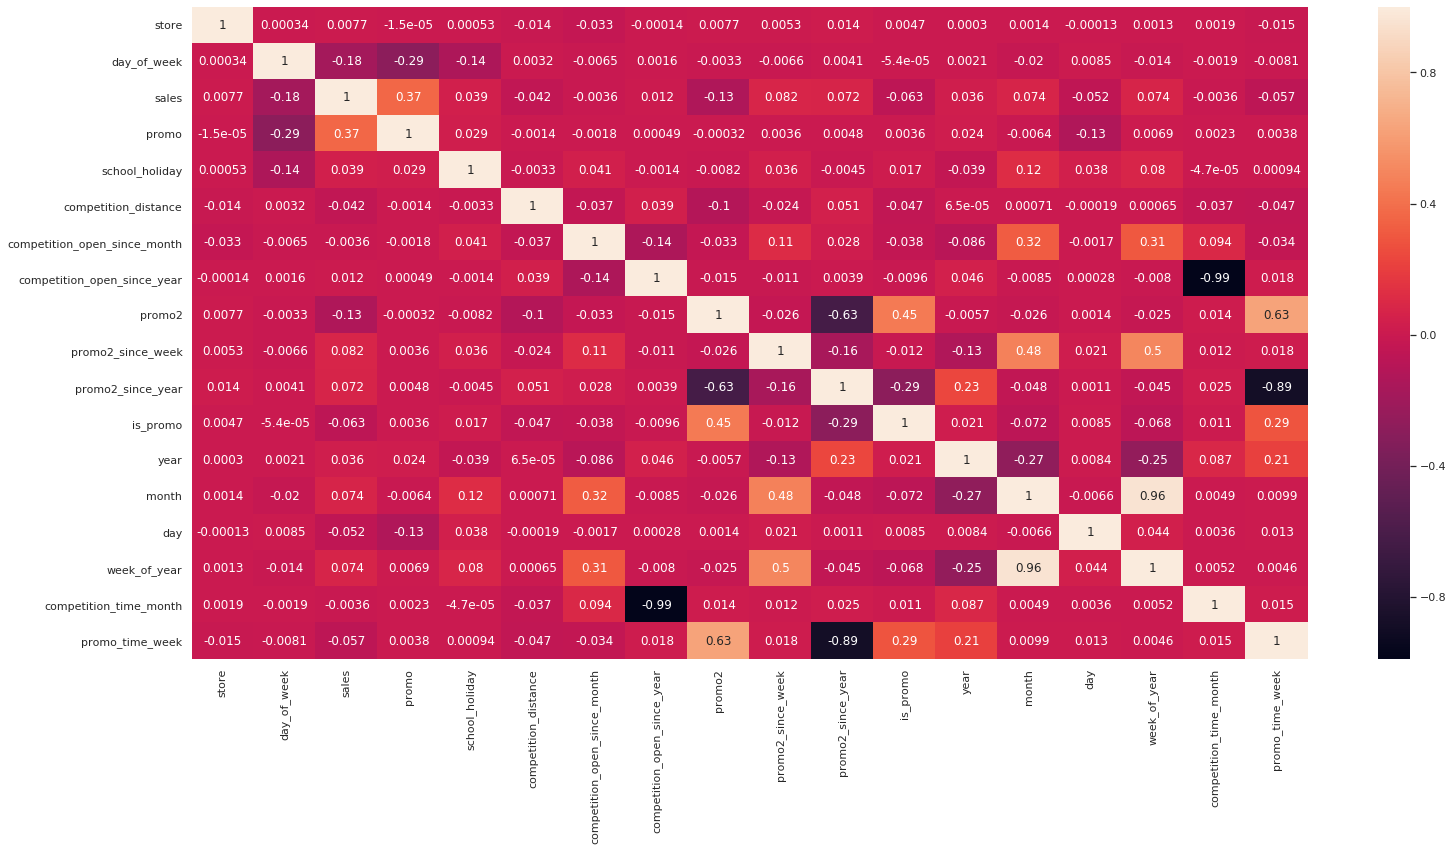

In [40]:
# estudo das correlações entre todos os atributos numéricos (definidos na seção 1.7)
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True);

### <i><font color="#a9a9a9" size=4>4.3.2 Categorical Attributes</font></i>

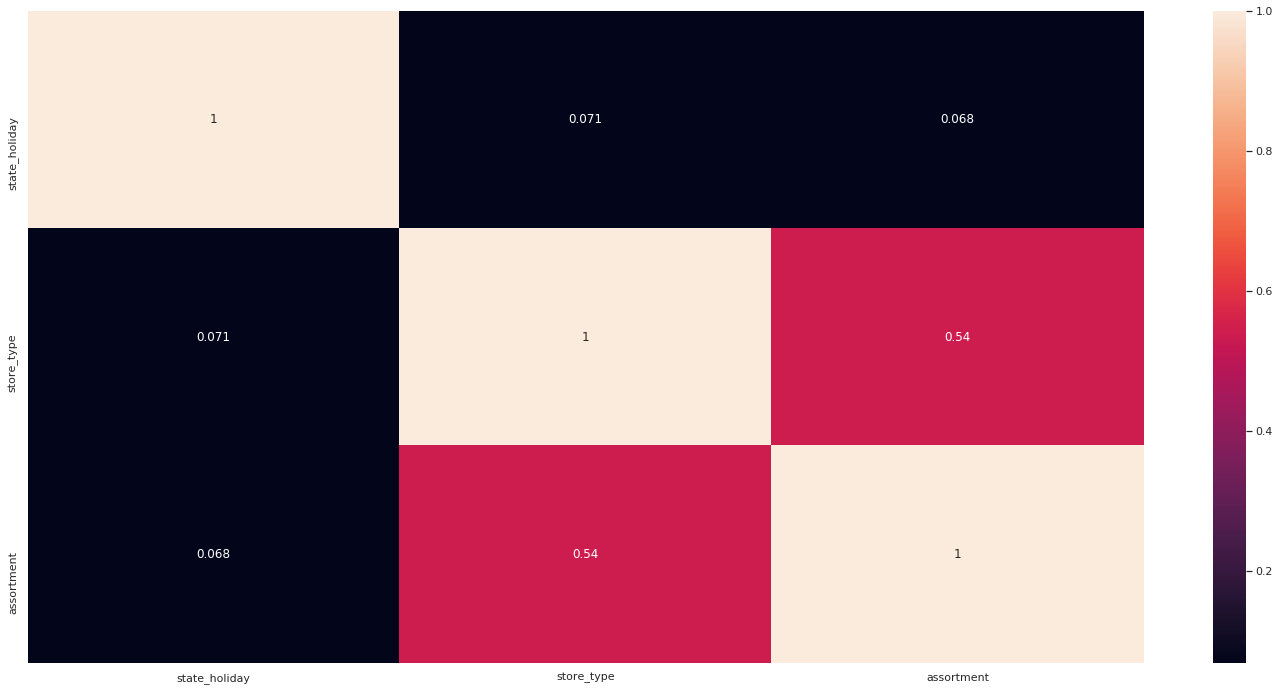

In [41]:
# seleção exclusiva de dados categóricos
a = df4.select_dtypes( include='object' )

# Calculate creamer_v
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                      'store_type': [a4, a5, a6],
                      'assortment': [a7, a8, a9]} )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True );

# 5º PASSO - Preparação dos Dados

In [42]:
# secutiry copy of dataset
df5 = df4.copy()

## <i><font color="#708090" size=5>5.1 Normalização</font></i>

In [ ]:
Image('img/Normal.png')

**Z:** valor normalizado
**Xi:** valor original
**μ:** média
**σ:** desvio padrão

Melhor aplicado a variáveis com distribuição normal. Neste caso não há variáveis com tal comportamento no dataset.

## <i><font color="#708090" size=5>5.2 Rescaling</font></i>

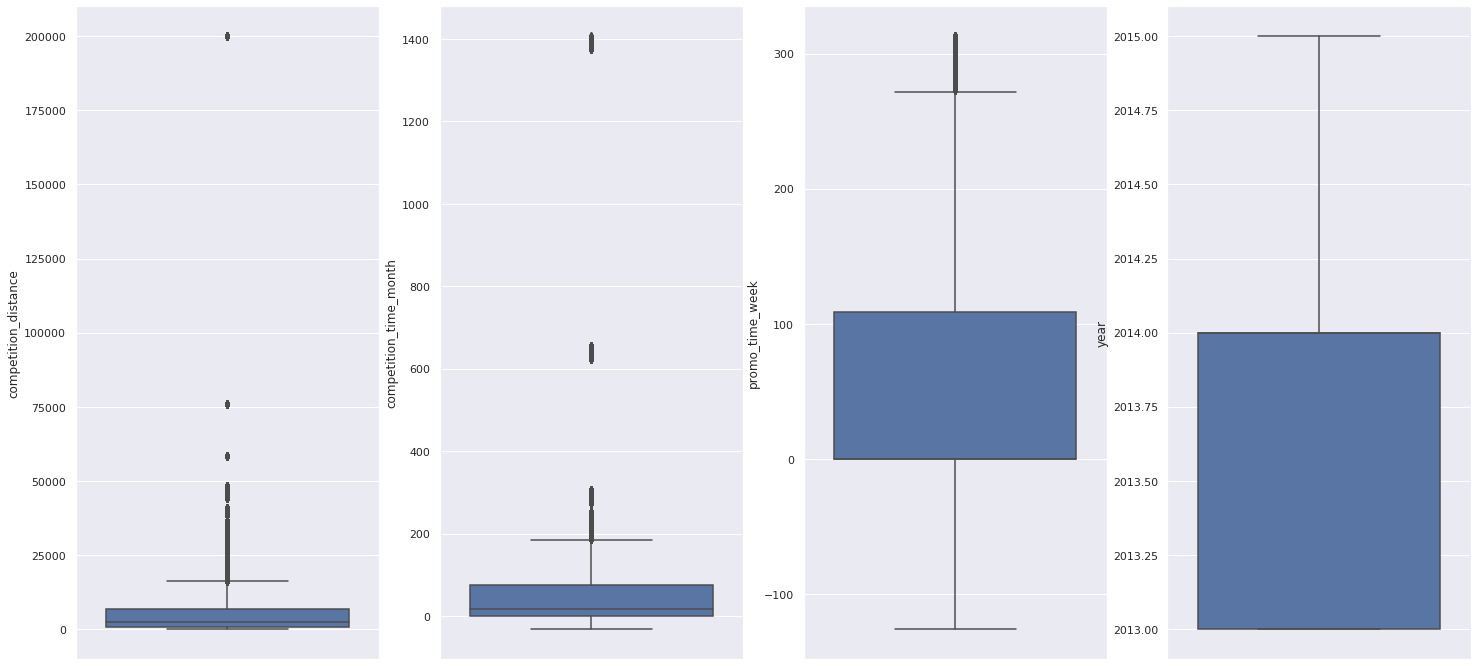

In [43]:
# avaliando a existência de outliers em cada variável
plt.subplot(1,4,1)
sns.boxplot( y=df5['competition_distance']);
plt.subplot(1,4,2)
sns.boxplot( y=df5['competition_time_month']);
plt.subplot(1,4,3)
sns.boxplot( y=df5['promo_time_week']);
plt.subplot(1,4,4)
sns.boxplot( y=df5['year']);

In [44]:
rs = RobustScaler(unit_variance=False)
mms = MinMaxScaler()

In [45]:
# competition_distance: muitos outliers
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition_time_month: muitos outliers
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo_time_week: poucos outliers
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year: nenhum outlier
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## <i><font color="#708090" size=5>5.3 Transformação</font></i>

### <i><font color="a9a9a9" size=4>5.3.1 Encoding</font></i>

In [46]:
# state_holiday: estado de feriado e não feriado (ONE HOT ENCODING)
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type: não há relação de ordem entre os níveis (LABEL ENCODING)
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment: há uma ordem implícita entre os níveis (ORDINAL ENCODING)
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

### <i><font color="a9a9a9" size=4>5.3.2 Response Variable Transformation</font></i>

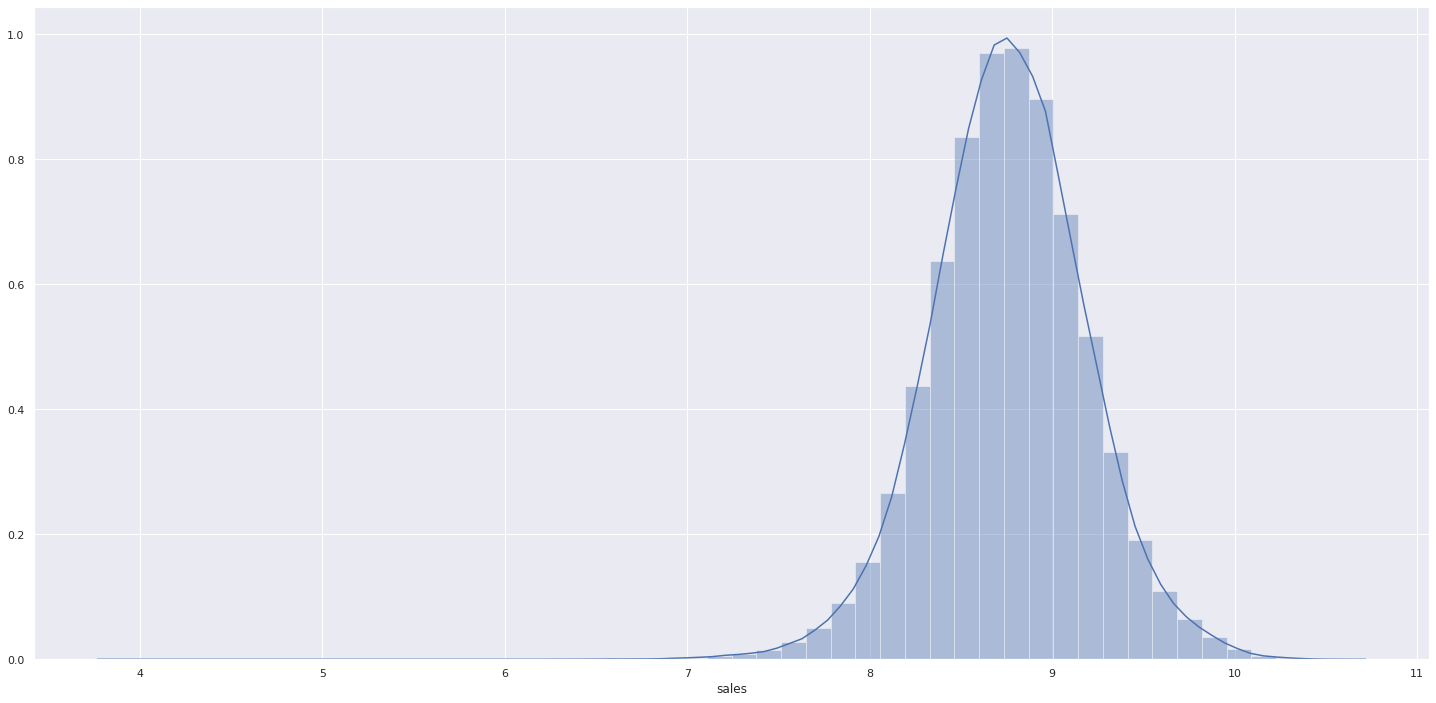

In [47]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot( df5['sales'] );

### <i><font color="a9a9a9" size=4>5.3.3 Nature Transformation</font></i>

In [48]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [49]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6º PASSO - Feature Selection

In [50]:
# secutiry copy of dataset
df6 = df5.copy()

## <i><font color="#708090" size=5>6.1 Split Dataframe into training and test dataset</font></i>

In [51]:
# deleção de colunas que deram origem a outras colunas nos passos anteriores
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [52]:
# descobrir a data de 6 semanas antes da última venda de todas as lojas
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=7*6 )

Timestamp('2015-06-19 00:00:00')

In [53]:
# Dados de Treino (Training Dataset): desde a primeira data até este dia (18/06/2015)
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Dados de Teste (Test Dataset): desde esta data (19/06/2015) até a última data
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Traning Min Date: {}'.format( x_train['date'].min() ) )
print( 'Traning Max Date: {}\n'.format( x_train['date'].max() ) )

print( 'Test Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## <i><font color="#708090" size=5>6.2 Boruta as Feature Selector</font></i>

In [173]:
# training and test dataset for Boruta: drop response columns
x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### <i><font color="a9a9a9" size=4>6.2.1 Best Features from Boruta</font></i>

In [174]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected Boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta) )

In [175]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [176]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## <i><font color="#708090" size=5>6.3 Manual Feature Selection</font></i>

In [54]:
# comparar com a validação de hipóteses da EDA (seção 4.2.2)
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend (feat_to_add)

# 7º PASSO - Machine Learning Modeling

In [55]:
# secutiry copy of dataset
df7 = df6.copy()

In [56]:
# filtragem dos dados de treino e teste a partir da sugestão do Boruta
x_train_ml = x_train[ cols_selected_boruta ]
x_test_ml = x_test[ cols_selected_boruta ] 
# dados de treino incluindo as features 'date' e 'sales'
x_training = x_train[cols_selected_boruta_full]

## <i><font color="#708090" size=5>7.1 Average Model</font></i>

In [180]:
aux1 = x_test_ml.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## <i><font color="#708090" size=5>7.2 Linear Regression Model</font></i>

In [181]:
# model
lr = LinearRegression().fit( x_train_ml, y_train )

# prediction
yhat_lr = lr.predict( x_test_ml )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### <i><font color="a9a9a9" size=4>7.2.1 Linear Regression Model - Cross Validation</font></i>

In [182]:
model = lr
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression CV', model, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## <i><font color="#708090" size=5>7.3 Linear Regression Regularized Model - Lasso</font></i>

In [183]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train_ml, y_train )

# prediction
yhat_lrr = lrr.predict( x_test_ml )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.285928,0.294716,2720.254331


### <i><font color="a9a9a9" size=4>7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation</font></i>

In [184]:
model = lrr
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression - Lasso CV', model, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso CV,2113.25 +/- 343.98,0.29 +/- 0.01,3047.69 +/- 509.99


## <i><font color="#708090" size=5>7.4 Random Forest Regressor</font></i>

In [185]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_ml, y_train )

# prediction
yhat_rf = rf.predict( x_test_ml )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.680255,0.099775,1009.520422


### <i><font color="a9a9a9" size=4>7.4.1 Random Forest Regressor - Cross Validation</font></i>

In [186]:
model = rf
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor CV', model, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor CV,837.61 +/- 218.13,0.12 +/- 0.02,1256.77 +/- 318.76


## <i><font color="#708090" size=5>7.5 XGBoost Regressor</font></i>

In [187]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train_ml, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test_ml )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,856.340259,0.124747,1266.041585


### <i><font color="a9a9a9" size=4>7.5.1 XGBoost Regressor - Cross Validation</font></i>

In [76]:
model = model_xgb
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor CV', model, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor CV,1041.51 +/- 191.12,0.14 +/- 0.02,1501.83 +/- 264.5


## <i><font color="#708090" size=5>7.6 Compare Model's Performance</font></i>

### <i><font color="a9a9a9" size=4>7.6.1 Single Performance</font></i>

In [188]:
single_performance = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
single_performance.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.680255,0.099775,1009.520422
0,XGBoost Regressor,856.340259,0.124747,1266.041585
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1890.285928,0.294716,2720.254331


**OBS.:** O problema de previsão de vendas em questão não é um modelo simples, mas complexo, dado o pior desempenho dos algoritmos de Regressão Linear. Ainda não se pode afirmar qual seja o melhor modelo antes de testar os algoritmos num conjunto de dados mais amplo do que o escolhido (6 últimas semanas)

### <i><font color="a9a9a9" size=4>7.6.2 Real Performance - Cross Validation</font></i>

In [78]:
real_performance = pd.concat([ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
real_performance.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor CV,837.95 +/- 218.28,0.12 +/- 0.02,1257.25 +/- 318.93
0,XGBoost Regressor CV,1041.51 +/- 191.12,0.14 +/- 0.02,1501.83 +/- 264.5
0,Linear Regression CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso CV,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8º PASSO - Hyperparameter Fine Tuning

## <i><font color="#708090" size=5>8.1 Random Search</font></i>

In [189]:
param = { 'n_estimators': [1500, 2000, 2500, 3000, 3500],
          'eta': [0.01, 0.03],
          'max_depth': [3, 5, 7, 9], 
          'subsample': [0.1, 0.5, 0.7], 
          'colsample_bytee': [0.3, 0.7, 0.9], 
          'min_child_weight': [3, 8, 15] }
MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytee'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    xgb_result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
    final_result = pd.concat( [final_result, xgb_result] )

final_result

## <i><font color="#708090" size=5>8.2 Final Model</font></i>

In [190]:
param_tuned = { 'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5, 
                'subsample': 0.7, 
                'colsample_bytee': 0.7, 
                'min_child_weight': 3 }


In [191]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytee=param_tuned['colsample_bytee'],
                              min_child_weight=param_tuned['min_child_weight']).fit( x_train_ml, y_train )
                                                          
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test_ml )                                                          

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,665.422825,0.096955,962.53445


# 9º PASSO: Tradução e Interpretação do Erro

In [88]:
df9 = x_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## <i><font color="#708090" size=5>9.1 Business Performance</font></i>

In [100]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( 
    lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( 
    lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [108]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,160864.828125,160587.828732,161141.827518,276.999393,0.063390
1,2,173305.359375,172930.890843,173679.827907,374.468532,0.076451
2,3,263418.781250,262868.691980,263968.870520,550.089270,0.078586
3,4,342394.218750,341527.104954,343261.332546,867.113796,0.082886
4,5,164903.406250,164536.842318,165269.970182,366.563932,0.081821


In [105]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103907.140625,100589.794228,107224.487022,3317.346397,0.567760
908,909,231949.890625,224194.282630,239705.498620,7755.607995,0.518750
875,876,202928.359375,198978.946650,206877.772100,3949.412725,0.307967
721,722,354602.375000,352567.067620,356637.682380,2035.307380,0.272425
594,595,392708.875000,389019.574060,396398.175940,3689.300940,0.254543


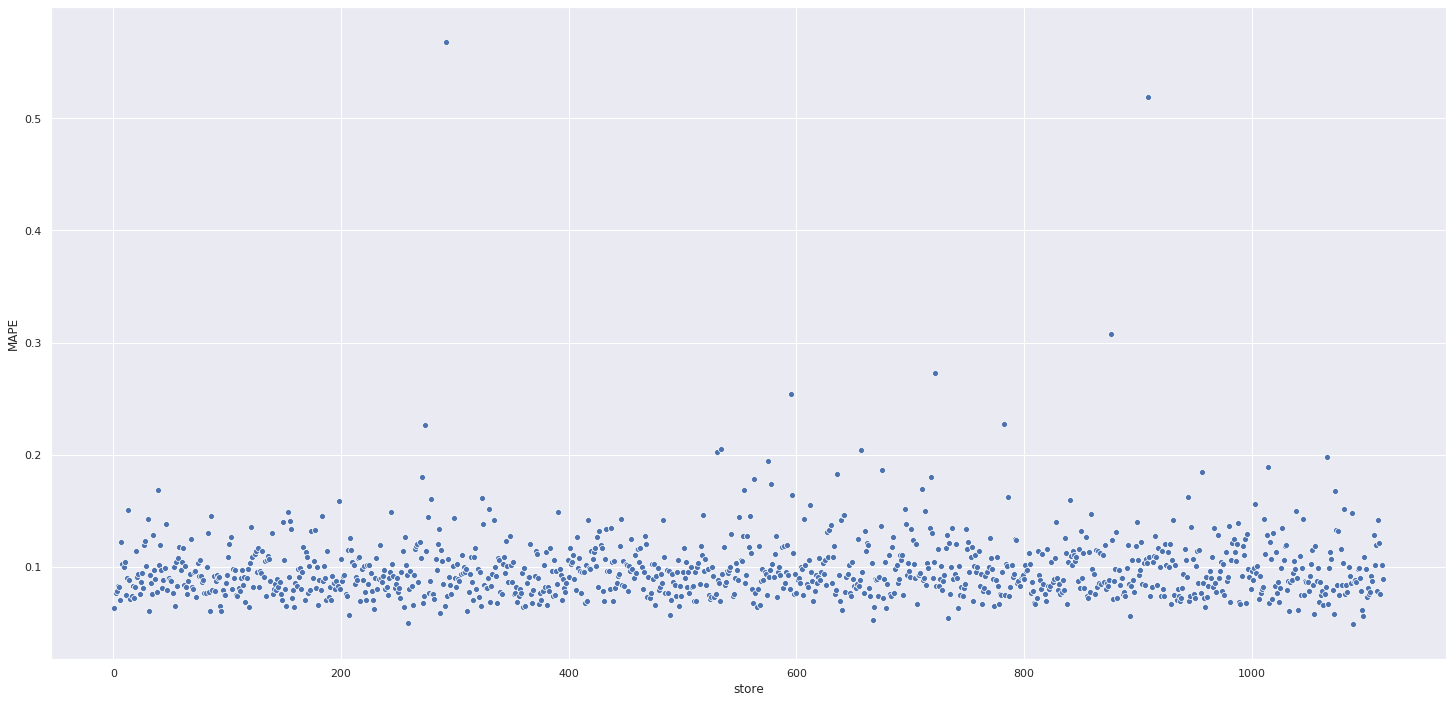

In [107]:
sns.scatterplot( x='store', y='MAPE', data=df92);

## <i><font color="#708090" size=5>9.2 Total Performance</font></i>

In [114]:
df9_total = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( 
    lambda x: np.sum(x), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df9_total['Values'] = df9_total['Values'].map( '${:,.2f}'.format )
df9_total

,Scenario,Values
0,predictions,"$283,951,842.24"
1,worst_scenario,"$283,203,495.28"
2,best_scenario,"$284,700,189.21"


## <i><font color="#708090" size=5>9.3 Machine Learning Performance</font></i>

In [117]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

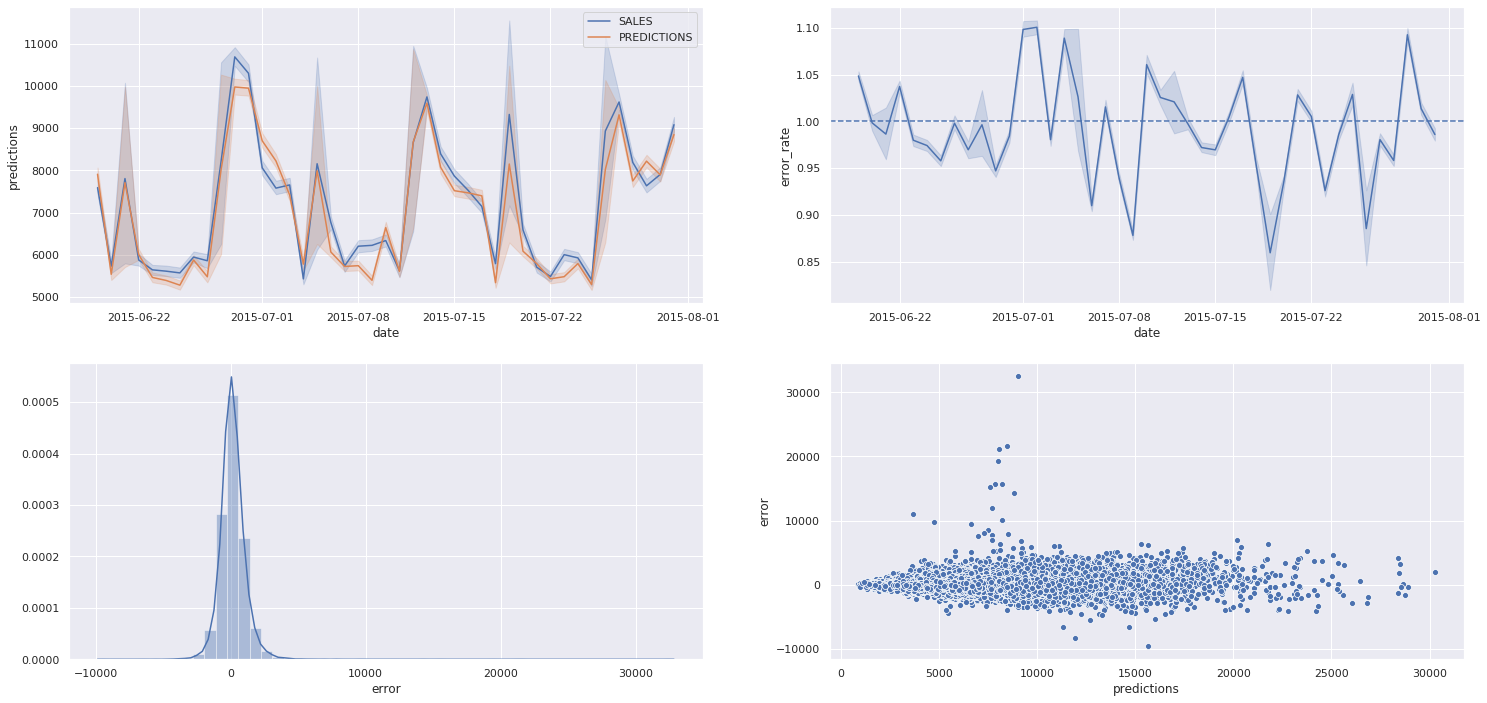

In [119]:
plt.subplot(2,2,1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot( x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot( df9['error'] );

plt.subplot(2,2,4)
sns.scatterplot( x=df9['predictions'], y=df9['error'], data=df9);

# 10º PASSO: Deploy Model to Production

In [206]:
# Save trained model: pkl
pickle.dump ( model_xgb_tuned, 
             open('/home/geordano/repos/DataScience_Em_Producao/model/model_rossmann_xgb142.pkl', 'wb') )

In [207]:
# Save trained model: json
model_xgb_tuned.save_model(
    '/home/geordano/repos/DataScience_Em_Producao/model/model_rossmann_xgb142.json')

In [214]:
# Save trained model: bin
model_xgb_tuned.save_model(
    '/home/geordano/repos/DataScience_Em_Producao/model/model_rossmann_xgb142.bin')

## <i><font color="#708090" size=5>10.1 Rossmann Class</font></i>

In [195]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/geordano/repos/DataScience_Em_Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
    
    
    def data_cleaning( self, df1 ):
        
        # Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new
        
        # Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        #competition_distance            NA=2642
        df1['competition_distance'] = df1['competition_distance'].apply( 
            lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month    NA=323348
        df1['competition_open_since_month'] = df1.apply( 
            lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
            else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year     NA=323348
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
            else x['competition_open_since_year'], axis=1 )

        #promo2_since_week               NA=508031
        df1['promo2_since_week'] = df1.apply( 
            lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
            else x['promo2_since_week'], axis=1 )

        #promo2_since_year               NA=508031
        df1['promo2_since_year'] = df1.apply( 
            lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
            else x['promo2_since_year'], axis=1 )

        #promo_interval                  NA=508031
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
            lambda x: 0 if x['promo_interval'] == 0 
            else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )
        
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( 
                                                        year=x['competition_open_since_year'],
                                                        month=x['competition_open_since_month'],
                                                        day=1 ), axis=1 )
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: 
                            datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 
                                                     'basic' if x=='a' else
                                                     'extra' if x=='b' else
                                                     'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 
                                                     'public_holiday' if x=='a' else
                                                     'easter_holiday' if x=='b' else
                                                     'christmas'      if x=='c' else
                                                     'regular_day')
        
        # Filtragem das Variáveis
        # Filtragem de Linhas
        # não interessa ao modelo open == 0, ou seja, quando as lojas estão fechadas
        df2 = df2[df2['open'] != 0]
        
        # Filtragem de colunas
        # 'customers' - não há como prever a quantidade de clientes nas pŕoximas 6 semanas
        # 'open' - após a filtragem das linhas, esta coluna só possui valores iguais a 1
        # 'promo_interval', 'month_map' - colunas auxiliares irrelevantes para esta etapa
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation( self, df5):
        
        # Rescaling
        # competition_distance: muitos outliers
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition_time_month: muitos outliers
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo_time_week: poucos outliers
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year: nenhum outlier
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        # Encoding
        # state_holiday: estado de feriado e não feriado (ONE HOT ENCODING)
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type: não há relação de ordem entre os níveis (LABEL ENCODING)
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment: há uma ordem implícita entre os níveis (ORDINAL ENCODING)
        assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # Nature transformation
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance',
        'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
        'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_sin', 'month_cos',
        'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']
        
        return df5[ cols_selected ]
    

    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )
        
        #join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )
        


## <i><font color="#708090" size=5>10.2 API Handler</font></i>

In [22]:
import pandas as pd
import pickle
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load ( open('/home/geordano/repos/DataScience_Em_Producao/model/model_rossmann_xgb142.pkl', 'rb' )
# model = xgb.XGBRegressor(use_label_encoder=False)
# model.load_model('/home/geordano/repos/DataScience_Em_Producao/model/model_rossmann_xgb142.json')
                     
# initialize API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature Engineering
        df2 = pipeline.feature_engineering ( df1 )
        
        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    

ModuleNotFoundError: No module named 'rossmann'

## <i><font color="#708090" size=5>10.3 API Tester</font></i>

In [61]:
# loading test dataset
df10 = pd.read_csv( '/home/geordano/repos/DataScience_Em_Producao/data/test.csv' )

In [74]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose stores for prediction
df_test = df_test[df_test['Store'].isin( [24, 12, 22, 67] ) ] # Example

# remove closed days, empty and drop ID
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1 )

In [75]:
# covert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [76]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-gds.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) ) 

# before run, handler.py must be on!!

Status Code 200


In [77]:
# View prediction
dpred1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [78]:
dpred2 = dpred1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( dpred2 ) ):
    print( 'Store Number {} will sell ${:,.2f} in the next 6 weeks'.format(
           dpred2.loc[i, 'store'],
           dpred2.loc[i, 'prediction'] ) )

# Total Sales all Stores
print( 'Total Sales for all stores: ${:,.2f}'.format( dpred2['prediction'].sum() ) )

Store Number 12 will sell $309,540.13 in the next 6 weeks
Store Number 22 will sell $206,675.90 in the next 6 weeks
Store Number 24 will sell $358,093.51 in the next 6 weeks
Store Number 67 will sell $313,663.09 in the next 6 weeks
Total Sales for all stores: $1,187,972.62
